# This notebook covers how to use the SE model to generate State embeddings for cells in a user-provided AnnData.

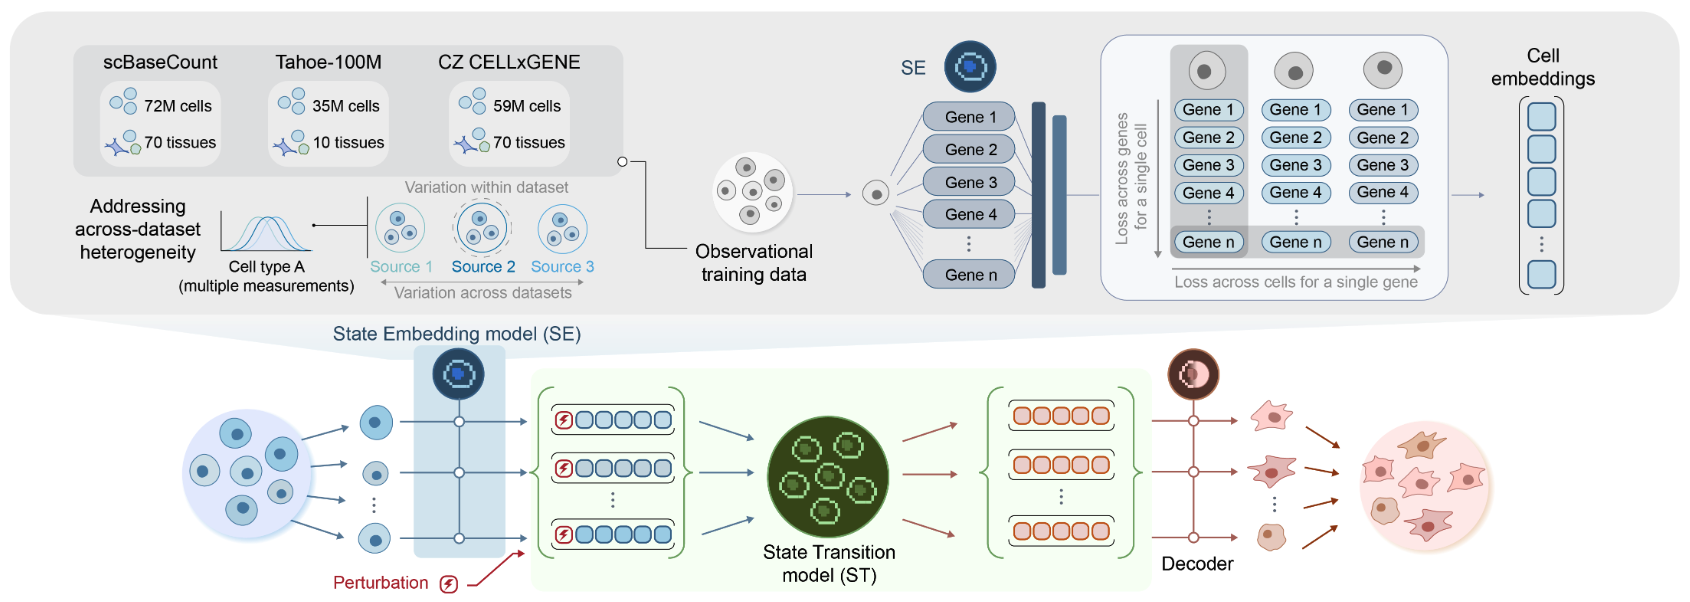

The State Embedding model can be used to obtain dense vector representations of single cells. These can then be used by the State Transition model to learn perturbational effects, or for other tasks such as cell type annotation, batch effect correction etc.

# Installations

In [ ]:
! pip -q install matplotlib-inline scanpy
! pip -q install -U "huggingface_hub>=0.22.0"

import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import os, sys

if 'MPLBACKEND' in os.environ:
    del os.environ['MPLBACKEND']

# Download the model folder, including checkpoints, from HuggingFace

In [ ]:
from huggingface_hub import snapshot_download

repo_id = "arcinstitute/SE-600M"
target_dir = "SE-600M"
exclude = ["se600m_epoch4.ckpt", "se600m_epoch4.safetensors"]

if os.path.exists(target_dir) and os.listdir(target_dir):
    raise SystemExit(f"'{target_dir}' already exists and is not empty.")

snapshot_download(
    repo_id=repo_id,
    repo_type="model",
    revision="main",
    local_dir=target_dir,
    local_dir_use_symlinks=False,  # copy files instead of symlinking from cache
    ignore_patterns=exclude,       # skip the big epoch-4 files
    resume_download=True,
)

print(f"Downloaded to ./{target_dir} (excluded: {', '.join(exclude)})")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:982: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a loc

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

MODEL_ACCEPTABLE_USE_POLICY.md: 0.00B [00:00, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

MODEL_LICENSE.md: 0.00B [00:00, ?B/s]

config.yaml: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/2.82G [00:00<?, ?B/s]

protein_embeddings.pt:   0%|          | 0.00/411M [00:00<?, ?B/s]

LICENSE.md: 0.00B [00:00, ?B/s]

README.md:   0%|          | 0.00/823 [00:00<?, ?B/s]

se600m_epoch16.ckpt:   0%|          | 0.00/11.5G [00:00<?, ?B/s]

Downloaded to ./SE-600M (excluded: se600m_epoch4.ckpt, se600m_epoch4.safetensors)


# Download some tissue data from Tabula Sapiens

In [ ]:
# Download tabula sapiens data

! wget https://datasets.cellxgene.cziscience.com/762edb8f-1207-4814-831e-99d7a801fdec.h5ad -O heart.h5ad
! wget https://datasets.cellxgene.cziscience.com/01e3402f-a625-4c4d-b94a-bc5996f738f7.h5ad -O kidney.h5ad
! wget https://datasets.cellxgene.cziscience.com/d6761a21-e226-434f-9370-fbcc7e549aa0.h5ad -O lung.h5ad

--2025-08-11 17:03:48--  https://datasets.cellxgene.cziscience.com/762edb8f-1207-4814-831e-99d7a801fdec.h5ad
Resolving datasets.cellxgene.cziscience.com (datasets.cellxgene.cziscience.com)... 3.170.229.116, 3.170.229.51, 3.170.229.26, ...
Connecting to datasets.cellxgene.cziscience.com (datasets.cellxgene.cziscience.com)|3.170.229.116|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1168741941 (1.1G) [binary/octet-stream]
Saving to: ‘heart.h5ad’

heart.h5ad          100%[===================>]   1.09G   361MB/s    in 3.1s    

2025-08-11 17:03:51 (361 MB/s) - ‘heart.h5ad’ saved [1168741941/1168741941]

--2025-08-11 17:03:51--  https://datasets.cellxgene.cziscience.com/d6761a21-e226-434f-9370-fbcc7e549aa0.h5ad
Resolving datasets.cellxgene.cziscience.com (datasets.cellxgene.cziscience.com)... 3.170.229.116, 3.170.229.51, 3.170.229.26, ...
Connecting to datasets.cellxgene.cziscience.com (datasets.cellxgene.cziscience.com)|3.170.229.116|:443... connected.
HTTP reque

In [ ]:
# Read the h5ad files
heart_adata = ad.read_h5ad("heart.h5ad")
kidney_adata = ad.read_h5ad("kidney.h5ad")
lung_adata = ad.read_h5ad("lung.h5ad")

# Concatenate the AnnData objects
concatenated_adata = ad.concat([heart_adata, kidney_adata, lung_adata], merge="unique")

# Write the concatenated AnnData object to a new h5ad file
concatenated_adata.write("processed.h5ad")

print("Concatenated data saved to processed.h5ad")

Concatenated data saved to processed.h5ad


# Compute the embedding using SE-600M

In [ ]:
# Embed the data (adds a .obsm['X_state'] property)
! uvx -q --from git+https://github.com/ArcInstitute/state@main state emb transform \
    --model-folder SE-600M \
    --input processed.h5ad \
    --output processed_emb.h5ad

# Alternative ways to run the model:

# Install the package:
# ! uv tool install arc-state
# ! state emb transform ...

INFO:state._cli._emb._transform:Using model checkpoint: SE-600M/se600m_epoch16.ckpt
INFO:state._cli._emb._transform:Creating inference object
INFO:state._cli._emb._transform:Loading model from checkpoint: SE-600M/se600m_epoch16.ckpt
INFO:state._cli._emb._transform:Computing embeddings for processed.h5ad
INFO:state._cli._emb._transform:Output will be saved to processed_emb.h5ad
INFO:/root/.cache/uv/archive-v0/lJS66_Dsp8_V7wOjQGeBF/lib/python3.11/site-packages/state/emb/data/loader.py:19631 genes mapped to embedding file (out of 61759)
!!! 19631 genes mapped to embedding file (out of 61759)
Encoding: 100% 2147/2147 [24:04<00:00,  1.49it/s]
INFO:state._cli._emb._transform:Embedding computation completed successfully!


# Compute PCA and plot data using gene expression, vs using the State Embeddings

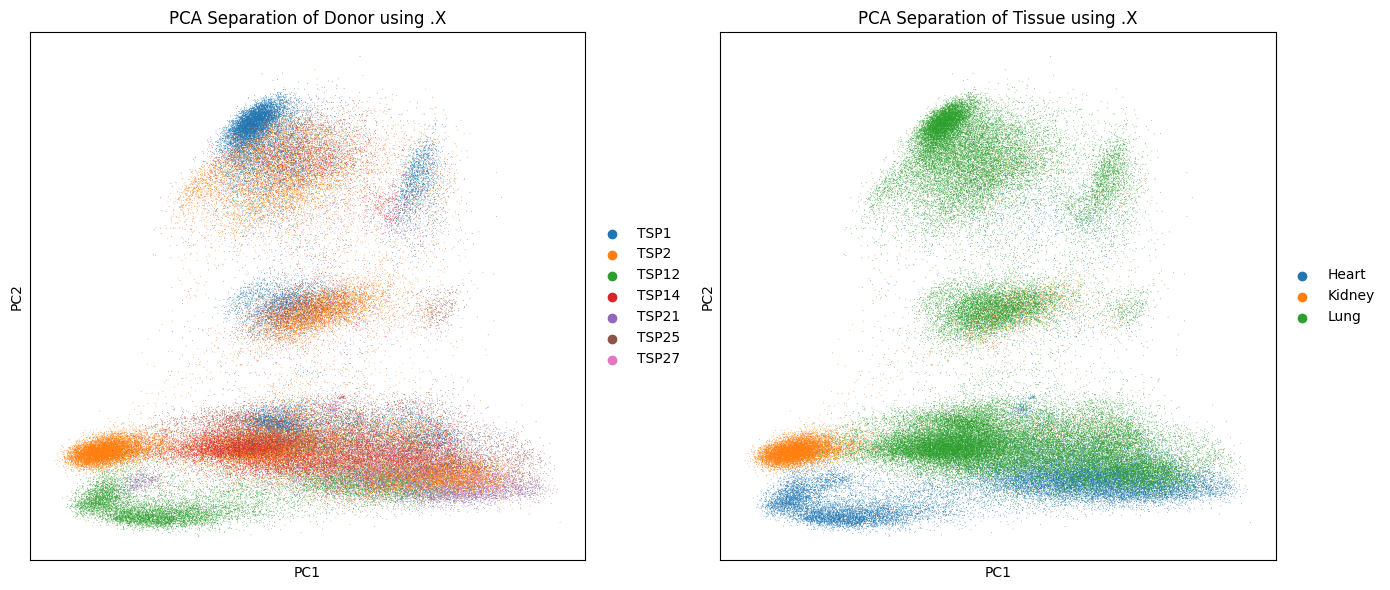

In [ ]:
# Create AnnData object for X_state and compute PCA

adata = sc.read("processed_emb.h5ad")

# Compute PCA on the gene expression data
sc.tl.pca(adata)

# Create figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: PCA using .X
sc.pl.pca(adata,
          color='donor_id',
          components=['1,2'],
          ax=axes[0],
          show=False,
          title="PCA Separation of Donor using .X")

# Plot 2: PCA using .obsm['X_state']
sc.pl.pca(adata,
          color='tissue_in_publication',
          components=['1,2'],
          ax=axes[1],
          show=False,
          title="PCA Separation of Tissue using .X")

# Adjust layout and show
plt.tight_layout()
plt.show()

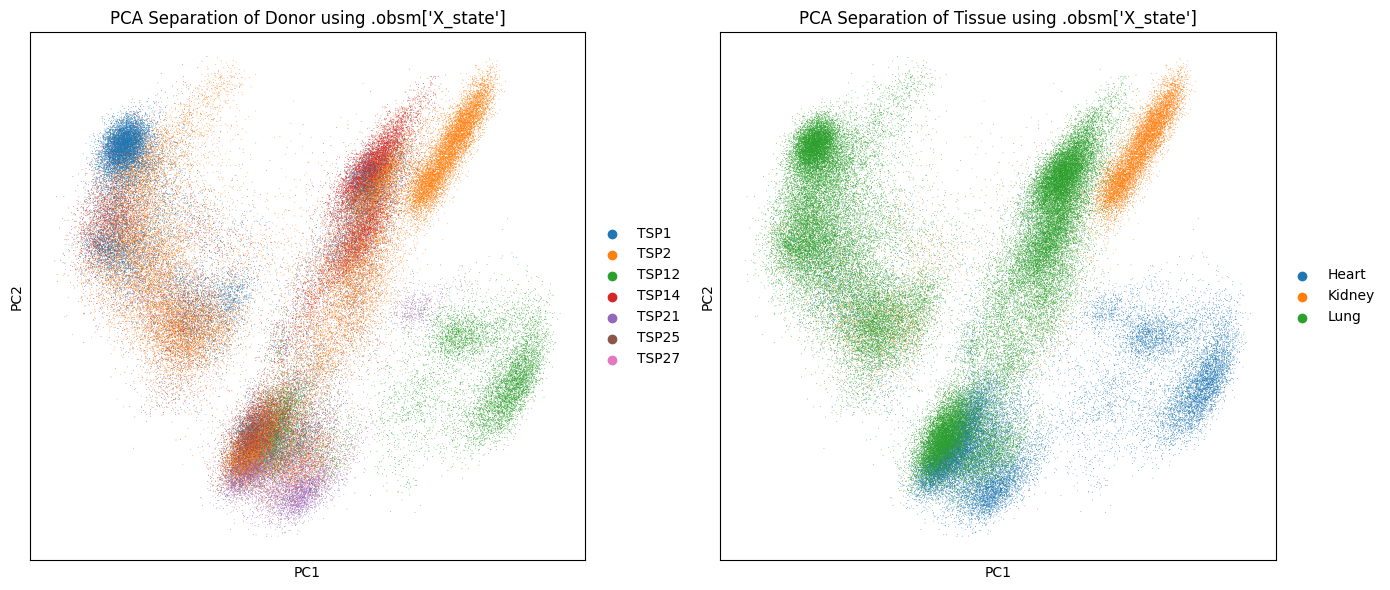

In [ ]:
# Create AnnData object for X_state and compute PCA
adata_state = ad.AnnData(adata.obsm['X_state'])
adata_state.obs_names = adata.obs_names
adata_state.obs['tissue_in_publication'] = adata.obs['tissue_in_publication']
adata_state.obs['donor_id'] = adata.obs['donor_id']
sc.tl.pca(adata_state)

# Create figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: PCA using .X
sc.pl.pca(adata_state,
          color='donor_id',
          components=['1,2'],
          ax=axes[0],
          show=False,
          title="PCA Separation of Donor using .obsm['X_state']")

# Plot 2: PCA using .obsm['X_state']
sc.pl.pca(adata_state,
          color='tissue_in_publication',
          components=['1,2'],
          ax=axes[1],
          show=False,
          title="PCA Separation of Tissue using .obsm['X_state']")

# Adjust layout and show
plt.tight_layout()
plt.show()